<a href="https://colab.research.google.com/github/pratyushjha06/Graph-Comparison-Tool/blob/main/Graph_Comparision_Tool.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **SETUP AND IMPORTS**

In [1]:
import os
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random

# Create project directory
PROJECT_DIR = "/content/graph_comparison_tool"
os.makedirs(PROJECT_DIR, exist_ok=True)
print("Project directory created at:", PROJECT_DIR)

# Install required libraries (only in Colab)
!pip install gdown networkx matplotlib pandas scikit-learn -q

Project directory created at: /content/graph_comparison_tool


# **LOAD DATASET FROM GOOGLE DRIVE**

In [2]:
import gdown

file_id = "1Fu4wmLDHHl-z6TXaTeiC21IH3-XQ-QfP"  # Elliptic transaction dataset
csv_path = os.path.join(PROJECT_DIR, "elliptic_txs_edgelist.csv")

if not os.path.exists(csv_path):
    print("Downloading dataset...")
    gdown.download(f"https://drive.google.com/uc?id={file_id}", csv_path, quiet=False)
else:
    print("Dataset already exists locally.")

df = pd.read_csv(csv_path)
print("Dataset loaded successfully! Total Rows:", len(df))
print(df.head())

Dataset already exists locally.
Dataset loaded successfully! Total Rows: 234355
       txId1      txId2
0  230425980    5530458
1  232022460  232438397
2  230460314  230459870
3  230333930  230595899
4  232013274  232029206


In [3]:
print("\nDataset Info:")
print(df.info())

print("\nMissing Values:")
print(df.isnull().sum())

print("\nColumns in Dataset:")
print(list(df.columns))


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234355 entries, 0 to 234354
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   txId1   234355 non-null  int64
 1   txId2   234355 non-null  int64
dtypes: int64(2)
memory usage: 3.6 MB
None

Missing Values:
txId1    0
txId2    0
dtype: int64

Columns in Dataset:
['txId1', 'txId2']


# **BUILD GRAPH FROM DATASET**

In [4]:
print("Building main graph...")

# Automatically detect source/target columns
possible_cols = list(df.columns)
source_col = possible_cols[0]
target_col = possible_cols[1]

G = nx.from_pandas_edgelist(df, source=source_col, target=target_col)
print(f"Main graph built successfully!\nTotal Nodes: {G.number_of_nodes()}\nTotal Edges: {G.number_of_edges()}")

Building main graph...
Main graph built successfully!
Total Nodes: 203769
Total Edges: 234355


# **SPLIT INTO LEGIT & FRAUD GRAPHS**

In [5]:
nodes_list = list(G.nodes())
random.shuffle(nodes_list)
split_index = len(nodes_list) // 2

nodes_legit = nodes_list[:split_index]
nodes_fraud = nodes_list[split_index:]

G_legit = G.subgraph(nodes_legit).copy()
G_fraud = G.subgraph(nodes_fraud).copy()

print(f"Graph A (Legit): {G_legit.number_of_nodes()} nodes, {G_legit.number_of_edges()} edges")
print(f"Graph B (Fraud): {G_fraud.number_of_nodes()} nodes, {G_fraud.number_of_edges()} edges")

Graph A (Legit): 101884 nodes, 58856 edges
Graph B (Fraud): 101885 nodes, 58431 edges


# **FUNCTION TO COMPUTE GRAPH METRICS**

In [6]:
def graph_metrics(G):
    metrics = {}
    metrics["Nodes"] = G.number_of_nodes()
    metrics["Edges"] = G.number_of_edges()
    metrics["Density"] = nx.density(G)
    metrics["Avg Clustering"] = nx.average_clustering(G)
    degrees = [d for _, d in G.degree()]
    metrics["Avg Degree"] = np.mean(degrees) if len(degrees) > 0 else 0
    return metrics

# **COMPUTE METRICS FOR BOTH GRAPHS**

In [7]:
metrics_legit = graph_metrics(G_legit)
metrics_fraud = graph_metrics(G_fraud)

print("\nLegit Graph Metrics:")
for k, v in metrics_legit.items():
    print(f"{k}: {v:.6f}")

print("\nFraud Graph Metrics:")
for k, v in metrics_fraud.items():
    print(f"{k}: {v:.6f}")


Legit Graph Metrics:
Nodes: 101884.000000
Edges: 58856.000000
Density: 0.000011
Avg Clustering: 0.006328
Avg Degree: 1.155353

Fraud Graph Metrics:
Nodes: 101885.000000
Edges: 58431.000000
Density: 0.000011
Avg Clustering: 0.005687
Avg Degree: 1.146999


# **CENTRALITY ANALYSIS**


Top 10 Central Nodes (Legit):
43388675: 0.001305
30699343: 0.001148
196107869: 0.000982
279187194: 0.000903
30179316: 0.000893
269905668: 0.000883
157929208: 0.000874
68706499: 0.000854
355110272: 0.000795
90716926: 0.000785

Top 10 Central Nodes (Fraud):
2984918: 0.002356
89273: 0.001600
68705820: 0.001266
96576418: 0.001099
225859042: 0.000972
234890810: 0.000972
232438397: 0.000893
43397277: 0.000844
121654821: 0.000736
149158766: 0.000726


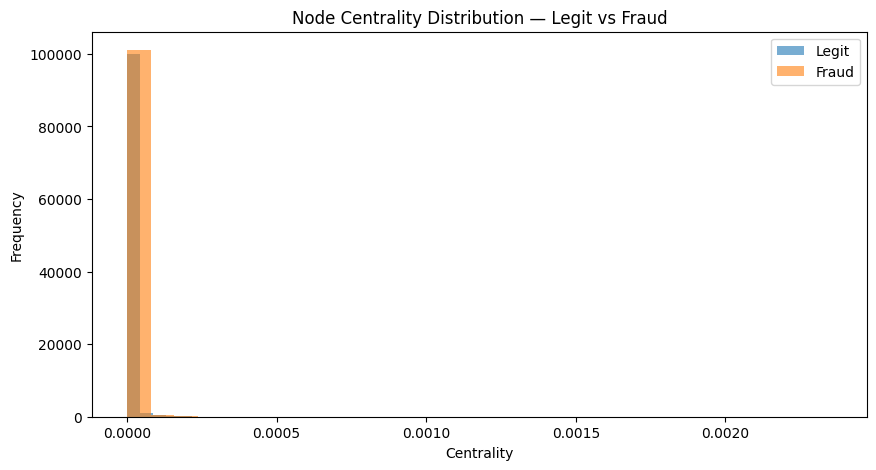

In [8]:
centrality_legit = nx.degree_centrality(G_legit)
centrality_fraud = nx.degree_centrality(G_fraud)

top_legit = sorted(centrality_legit.items(), key=lambda x: x[1], reverse=True)[:10]
top_fraud = sorted(centrality_fraud.items(), key=lambda x: x[1], reverse=True)[:10]

print("\nTop 10 Central Nodes (Legit):")
for node, cent in top_legit:
    print(f"{node}: {cent:.6f}")

print("\nTop 10 Central Nodes (Fraud):")
for node, cent in top_fraud:
    print(f"{node}: {cent:.6f}")

# Plot centrality distributions
plt.figure(figsize=(10,5))
plt.hist(list(centrality_legit.values()), bins=30, alpha=0.6, label="Legit")
plt.hist(list(centrality_fraud.values()), bins=30, alpha=0.6, label="Fraud")
plt.title("Node Centrality Distribution — Legit vs Fraud")
plt.xlabel("Centrality")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# **VISUAL COMPARISON (BAR CHARTS)**

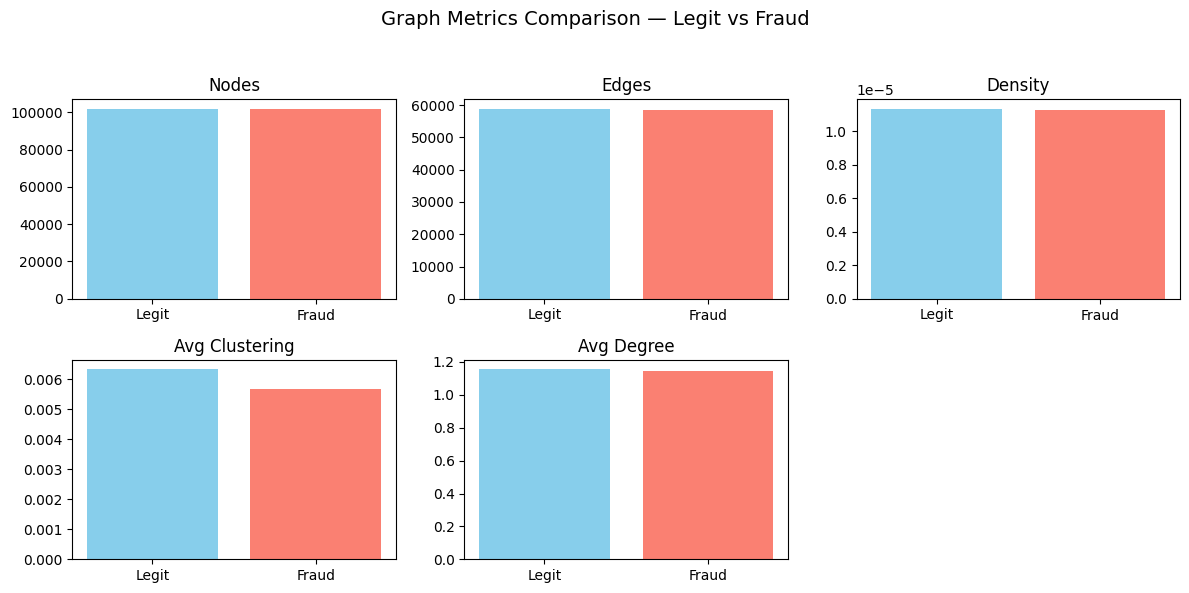

In [9]:
metrics = list(metrics_legit.keys())
values_legit = list(metrics_legit.values())
values_fraud = list(metrics_fraud.values())

plt.figure(figsize=(12,6))
for i, metric in enumerate(metrics):
    plt.subplot(2, 3, i+1)
    plt.bar(["Legit", "Fraud"], [values_legit[i], values_fraud[i]], color=['skyblue', 'salmon'])
    plt.title(metric)
plt.suptitle("Graph Metrics Comparison — Legit vs Fraud", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


# ***SAVE RESULTS***

In [10]:
#  Create a clean metrics comparison DataFrame
metrics_df = pd.DataFrame(
    [metrics_legit, metrics_fraud],
    index=["Legit Transactions Graph", "Fraud Transactions Graph"]
)

print("\n=== Graph Metrics Comparison ===")
display(metrics_df.round(6))


=== Graph Metrics Comparison ===


,Nodes,Edges,Density,Avg Clustering,Avg Degree
Legit Transactions Graph,101884,58856,0.000011,0.006328,1.155353
Fraud Transactions Graph,101885,58431,0.000011,0.005687,1.146999
